In [1]:
import requests
import pandas as pd

API_KEY = 'RqDy60O7DAKhvOBhy+dgnxKYpxIS6RmDUzU7eY6W2rOTg6S7E1pqNRfIaEFGS865'

headers = {
    'Authorization': f'Bearer {API_KEY}',
    'Accept': 'application/json'
}

base_url = 'https://api.collegefootballdata.com'
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'

# Pull 2025 regular season games
response = requests.get(
    f'{base_url}/games',
    headers=headers,
    params={'year': 2025, 'seasonType': 'regular'}
)

games = response.json()
df_games = pd.DataFrame(games)
df_games.to_csv(f'{data_path}\\cfb_games_2025.csv', index=False)

print(f"Games pulled: {len(df_games)}")
print(f"Columns: {df_games.columns.tolist()}")
print(df_games.head())

Games pulled: 3745
Columns: ['id', 'season', 'week', 'seasonType', 'startDate', 'startTimeTBD', 'completed', 'neutralSite', 'conferenceGame', 'attendance', 'venueId', 'venue', 'homeId', 'homeTeam', 'homeClassification', 'homeConference', 'homePoints', 'homeLineScores', 'homePostgameWinProbability', 'homePregameElo', 'homePostgameElo', 'awayId', 'awayTeam', 'awayClassification', 'awayConference', 'awayPoints', 'awayLineScores', 'awayPostgameWinProbability', 'awayPregameElo', 'awayPostgameElo', 'excitementIndex', 'highlights', 'notes']
          id  season  week seasonType                 startDate  startTimeTBD  \
0  401756846    2025     1    regular  2025-08-23T16:00:00.000Z         False   
1  401767476    2025     1    regular  2025-08-23T17:00:00.000Z         False   
2  401760371    2025     1    regular  2025-08-23T20:00:00.000Z         False   
3  401767126    2025     1    regular  2025-08-23T20:30:00.000Z         False   
4  401756847    2025     1    regular  2025-08-23T22:30

In [10]:
import pandas as pd
import numpy as np

data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'

# Load data
df = pd.read_csv(f'{data_path}\\cfb_games_2025.csv')

# Filter to completed games where at least one team is FBS or FCS
df = df[
    (df['completed'] == True) & 
    (df['homeClassification'].isin(['fbs', 'fcs'])) & 
    (df['awayClassification'].isin(['fbs', 'fcs']))
].copy()
print(f"FBS vs FBS completed games: {len(df)}")

# Calculate margin from home team perspective
df['home_margin'] = df['homePoints'] - df['awayPoints']

# Get unique teams
teams = sorted(set(df['homeTeam'].unique()) | set(df['awayTeam'].unique()))
n_teams = len(teams)
print(f"FBS Teams: {n_teams}")

# Build game list for each team: (opponent, margin, is_home, is_neutral)
team_games = {team: [] for team in teams}

for _, game in df.iterrows():
    home = game['homeTeam']
    away = game['awayTeam']
    margin = game['home_margin']
    neutral = game['neutralSite']
    
    team_games[home].append({'opponent': away, 'margin': margin, 'is_home': True, 'neutral': neutral})
    team_games[away].append({'opponent': home, 'margin': -margin, 'is_home': False, 'neutral': neutral})

# Step 1: Calculate raw average MOV for each team
avg_mov = {}
for team in teams:
    margins = [g['margin'] for g in team_games[team]]
    avg_mov[team] = np.mean(margins) if margins else 0

# Step 2: Estimate HFA from home vs away performance
home_margins = []
for team in teams:
    home_games = [g['margin'] for g in team_games[team] if g['is_home'] and not g['neutral']]
    away_games = [g['margin'] for g in team_games[team] if not g['is_home'] and not g['neutral']]
    
    if home_games and away_games:
        home_margins.append(np.mean(home_games) - np.mean(away_games))

hfa = np.mean(home_margins) / 2  # Divide by 2 because home-away diff captures 2x HFA
print(f"\nEstimated Home Field Advantage: {hfa:.2f} points")

# Step 3: Calculate HFA-adjusted margins
team_adj_margins = {team: [] for team in teams}
for team in teams:
    for g in team_games[team]:
        if g['neutral']:
            adj_margin = g['margin']
        elif g['is_home']:
            adj_margin = g['margin'] - hfa  # Remove home advantage
        else:
            adj_margin = g['margin'] + hfa  # Remove away disadvantage
        team_adj_margins[team].append({'opponent': g['opponent'], 'adj_margin': adj_margin})

# Step 4: Iterative SRS calculation
srs = {team: np.mean([g['adj_margin'] for g in team_adj_margins[team]]) for team in teams}

for iteration in range(100):
    new_srs = {}
    for team in teams:
        games = team_adj_margins[team]
        avg_adj_margin = np.mean([g['adj_margin'] for g in games])
        avg_opp_srs = np.mean([srs[g['opponent']] for g in games])
        new_srs[team] = avg_adj_margin + avg_opp_srs
    
    # Check convergence
    max_change = max(abs(new_srs[t] - srs[t]) for t in teams)
    srs = new_srs
    
    if max_change < 0.001:
        print(f"Converged after {iteration + 1} iterations")
        break

# Normalize so average = 0
mean_srs = np.mean(list(srs.values()))
srs = {team: rating - mean_srs for team, rating in srs.items()}

# Create results dataframe
results = pd.DataFrame({
    'team': list(srs.keys()),
    'srs_rating': list(srs.values())
})
results = results.sort_values('srs_rating', ascending=False).reset_index(drop=True)
results['srs_rank'] = range(1, len(results) + 1)

# Add average MOV for reference
results['avg_mov'] = results['team'].map(avg_mov)

# Calculate Strength of Schedule (SOS) = average opponent SRS
sos = {}
for team in teams:
    opponents = [g['opponent'] for g in team_adj_margins[team]]
    sos[team] = np.mean([srs[opp] for opp in opponents])

results['sos'] = results['team'].map(sos)
results['sos_rank'] = results['sos'].rank(ascending=False).astype(int)

print(f"\nTop 25 by SRS:")
print(results[['srs_rank', 'team', 'srs_rating', 'avg_mov', 'sos', 'sos_rank']].head(25).to_string(index=False))

# Save
results.to_csv(f'{data_path}\\cfb_srs_2025.csv', index=False)
print(f"\nSaved to cfb_srs_2025.csv")

FBS vs FBS completed games: 1570
FBS Teams: 265

Estimated Home Field Advantage: 5.99 points
Converged after 65 iterations

Top 25 by SRS:
 srs_rank          team  srs_rating   avg_mov       sos  sos_rank
        1       Indiana   49.828990 31.076923 19.674303        18
        2    Ohio State   44.888671 26.769231 19.041725        30
        3        Oregon   43.938894 23.333333 21.604635         5
        4    Texas Tech   43.104827 31.538462 12.488658        66
        5    Notre Dame   42.134407 24.416667 18.716855        31
        6          Utah   38.781906 22.416667 16.365440        45
        7         Miami   35.410742 20.250000 17.158773        39
        8           USC   34.003919 14.083333 20.919703        11
        9       Georgia   33.339718 16.000000 19.184064        24
       10       Alabama   32.949674 13.846154 20.025782        15
       11    Vanderbilt   32.726870 17.500000 16.225977        46
       12           BYU   32.527187 12.923077 19.604321        19
   

In [54]:
import pandas as pd
import numpy as np

data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'

# Load data
df = pd.read_csv(f'{data_path}\\cfb_games_2025.csv')

# Filter to completed FBS/FCS games with excitement index
df = df[
    (df['completed'] == True) & 
    (df['homeClassification'].isin(['fbs', 'fcs'])) & 
    (df['awayClassification'].isin(['fbs', 'fcs'])) &
    (df['excitementIndex'].notna())
].copy()

print(f"Games with excitement index: {len(df)}")

# Get unique teams
teams = sorted(set(df['homeTeam'].unique()) | set(df['awayTeam'].unique()))
n_teams = len(teams)
print(f"Teams: {n_teams}")

# Convert excitement to dominance
exc_min = df['excitementIndex'].min()
exc_max = df['excitementIndex'].max()

def excitement_to_dominance(exc):
    return 1 - (exc - exc_min) / (exc_max - exc_min)

df['dominance'] = df['excitementIndex'].apply(excitement_to_dominance)

# Build game results with performance scores
team_games = {team: [] for team in teams}

for _, game in df.iterrows():
    home = game['homeTeam']
    away = game['awayTeam']
    home_win = game['homePoints'] > game['awayPoints']
    dominance = game['dominance']
    neutral = game['neutralSite']

    # Performance score: 0.5 to 1.0 for wins, 0.0 to 0.5 for losses
    if home_win:
        home_perf = 0.5 + 0.5 * dominance
        away_perf = 0.5 - 0.5 * dominance
    else:
        home_perf = 0.5 - 0.5 * dominance
        away_perf = 0.5 + 0.5 * dominance
    
    team_games[home].append({'opponent': away, 'performance': home_perf, 'is_home': True, 'neutral': neutral})
    team_games[away].append({'opponent': home, 'performance': away_perf, 'is_home': False, 'neutral': neutral})

# Calculate average performance
avg_perf = {team: np.mean([g['performance'] for g in team_games[team]]) for team in teams}

# Bradley-Terry in LOG-ODDS space (keeps values bounded)
# logit(p) = log(p / (1-p))
# This is the natural scale for probabilities

def prob_to_logit(p):
    p = np.clip(p, 0.001, 0.999)
    return np.log(p / (1 - p))

def logit_to_prob(logit):
    return 1 / (1 + np.exp(-logit))

# Initialize power in logit space based on average performance
power_logit = {team: prob_to_logit(avg_perf[team]) for team in teams}

# =============================================================================
# ESTIMATE HOME FIELD ADVANTAGE FROM DATA
# =============================================================================

home_perfs = []
away_perfs = []

for team in teams:
    for g in team_games[team]:
        if g['neutral']:
            continue
        if g['is_home']:
            home_perfs.append(g['performance'])
        else:
            away_perfs.append(g['performance'])

avg_home_perf = np.mean(home_perfs)
avg_away_perf = np.mean(away_perfs)

# Convert to logit space
home_logit = prob_to_logit(avg_home_perf)
away_logit = prob_to_logit(avg_away_perf)

# HFA is half the difference (since home-away captures 2x the advantage)
HFA_LOGIT = (home_logit - away_logit) / 2

print(f"Home avg performance: {avg_home_perf:.4f}")
print(f"Away avg performance: {avg_away_perf:.4f}")
print(f"Estimated HFA (logit): {HFA_LOGIT:.4f}")
print(f"HFA as probability boost: {(logit_to_prob(HFA_LOGIT) - 0.5) * 100:.1f}%")

# =============================================================================
# ITERATIVE POWER RATING ESTIMATION
# =============================================================================
print("\nOptimizing...")
for iteration in range(1000):
    new_power_logit = {}
    
    for team in teams:
        games = team_games[team]
        if not games:
            new_power_logit[team] = 0
            continue
        
        # For each game, calculate what our performance "should" mean given opponent strength
        # If we scored 0.8 performance against a +2 logit team, we're better than 0.8
        # Expected performance vs opponent: logit(perf) = power_us - power_opp
        # So: power_us = logit(perf) + power_opp
        
        implied_powers = []
        for g in games:
            perf_logit = prob_to_logit(g['performance'])
            opp_power = power_logit[g['opponent']]
            
            # Adjust for home field
            if g['neutral']:
                hfa_adj = 0
            elif g['is_home']:
                hfa_adj = -HFA_LOGIT
            else:
                hfa_adj = HFA_LOGIT

            implied_power = perf_logit + opp_power
            implied_powers.append(implied_power)
        
        new_power_logit[team] = np.mean(implied_powers)
    
    # Center so average = 0 (average team has 50% chance vs average)
    mean_logit = np.mean(list(new_power_logit.values()))
    new_power_logit = {t: lp - mean_logit for t, lp in new_power_logit.items()}
    
    # Check convergence
    max_change = max(abs(new_power_logit[t] - power_logit[t]) for t in teams)
    power_logit = new_power_logit
    
    if max_change < 0.0001:
        print(f"Converged after {iteration + 1} iterations")
        break

print(f"Final max change: {max_change:.6f}")

# Convert to probability (this IS the probability of beating average team)
power_scores = {t: logit_to_prob(lp) for t, lp in power_logit.items()}

# =============================================================================
# GAME POWER RATING (1-100 scale)
# =============================================================================

# Get all implied logits across all games (WITH HFA)
all_implied_logits = []
for team in teams:
    for g in team_games[team]:
        perf_logit = prob_to_logit(g['performance'])
        opp_logit = power_logit[g['opponent']]
        
        if g['neutral']:
            hfa_adj = 0
        elif g['is_home']:
            hfa_adj = -HFA_LOGIT
        else:
            hfa_adj = +HFA_LOGIT
        
        implied = perf_logit + opp_logit + hfa_adj
        all_implied_logits.append(implied)

logit_min = min(all_implied_logits)
logit_max = max(all_implied_logits)

def logit_to_100(logit):
    return 1 + 99 * (logit - logit_min) / (logit_max - logit_min)

# Calculate average game rating (1-100) for each team
avg_game_rating = {}
for team in teams:
    game_ratings = []
    for g in team_games[team]:
        perf_logit = prob_to_logit(g['performance'])
        opp_logit = power_logit[g['opponent']]
        
        if g['neutral']:
            hfa_adj = 0
        elif g['is_home']:
            hfa_adj = -HFA_LOGIT
        else:
            hfa_adj = +HFA_LOGIT
        
        implied = perf_logit + opp_logit + hfa_adj
        game_ratings.append(logit_to_100(implied))
    avg_game_rating[team] = np.mean(game_ratings)

# =============================================================================
# WINS ABOVE AVERAGE (WAA) - Strength of Record
# =============================================================================

# For each game, calculate expected win probability for average team (power = 0.5)
# P(avg beats opp) = 0.5 / (0.5 + opp_power) ... but we're in logit space
# In logit space: P(avg beats opp) = 1 / (1 + exp(opp_logit - 0)) = 1 / (1 + exp(opp_logit))
# Which simplifies to: P(avg beats opp) = 1 - opp_power_score

waa = {}
for team in teams:
    team_waa = 0
    for g in team_games[team]:
        opp = g['opponent']
        opp_power = power_scores[opp]
        
        # Probability average team beats this opponent
        prob_avg_wins = 1 - opp_power
        
        # WAA for this game
        if g['performance'] > 0.5:  # Win
            game_waa = 1 - prob_avg_wins  # Credit for winning a hard game
        else:  # Loss
            game_waa = -prob_avg_wins  # Penalty for losing (less penalty if opponent strong)
        
        team_waa += game_waa
    
    waa[team] = team_waa

# =============================================================================
# HYBRID RANKING - 50/50 Power Score + WAA
# =============================================================================

# Convert to z-scores
power_mean = np.mean(list(power_scores.values()))
power_std = np.std(list(power_scores.values()))
power_z = {t: (p - power_mean) / power_std for t, p in power_scores.items()}

waa_mean = np.mean(list(waa.values()))
waa_std = np.std(list(waa.values()))
waa_z = {t: (w - waa_mean) / waa_std for t, w in waa.items()}

# Combined z-score (50/50)
combined_z = {t: power_z[t] + waa_z[t] for t in teams}

# Scale to 1-100
combined_min = min(combined_z.values())
combined_max = max(combined_z.values())
hybrid_score = {t: 1 + 99 * (combined_z[t] - combined_min) / (combined_max - combined_min) for t in teams}

# Create results
results = pd.DataFrame({
    'team': list(power_scores.keys()),
    'power_score': list(power_scores.values()),
    'power_logit': [power_logit[t] for t in power_scores.keys()]
})

results['avg_raw_performance'] = results['team'].map(avg_perf)
results['games'] = results['team'].apply(lambda t: len(team_games[t]))

results['avg_adj_performance'] = results['team'].map(avg_game_rating)
results['power_rank'] = results['power_score'].rank(ascending=False).astype(int)

results['waa'] = results['team'].map(waa)
results['waa_rank'] = results['waa'].rank(ascending=False).astype(int)

results['power_z'] = results['team'].map(power_z)
results['waa_z'] = results['team'].map(waa_z)
results['hybrid_score'] = results['team'].map(hybrid_score)
results['hybrid_rank'] = results['hybrid_score'].rank(ascending=False).astype(int)

results = results.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

# SOS = average opponent power score
sos = {}
for team in teams:
    opponents = [g['opponent'] for g in team_games[team]]
    sos[team] = np.mean([power_scores[opp] for opp in opponents])

results['sos'] = results['team'].map(sos)
results['sos_rank'] = results['sos'].rank(ascending=False).astype(int)

print(f"\nTop 25 Playoff Rankings:")
print(results[['hybrid_rank', 'team', 'hybrid_score', 'games', 'avg_adj_performance', 'power_rank', 'waa', 'waa_rank', 'sos', 'sos_rank']].head(25).to_string(index=False))

results.to_csv(f'{data_path}\\cfb_power_score_2025.csv', index=False)
print(f"\nSaved to cfb_power_score_2025.csv")

Games with excitement index: 1516
Teams: 265
Home avg performance: 0.5969
Away avg performance: 0.4031
Estimated HFA (logit): 0.3927
HFA as probability boost: 9.7%

Optimizing...
Converged after 66 iterations
Final max change: 0.000094

Top 25 Playoff Rankings:
 hybrid_rank          team  hybrid_score  games  avg_adj_performance  power_rank       waa  waa_rank      sos  sos_rank
           1       Indiana    100.000000     13            80.891730           2 10.294549         1 0.791888        25
           2       Georgia     97.181246     13            78.484089           4  9.439161         2 0.803012        19
           3    Ohio State     97.022185     13            82.616905           1  9.305949         3 0.792765        24
           4        Oregon     95.236624     12            80.175843           3  8.783146         4 0.815262        14
           5     Texas A&M     93.106992     12            73.913665           9  8.326404         5 0.777200        37
           6      


DIAGNOSTIC: Notre Dame vs Miami

Notre Dame:
  Avg Performance: 0.7911
  Power Logit: 3.5493
  Power Score: 0.9721
  SOS: 0.8013

  Game-by-game implied power:
    L A vs Miami                     perf=0.116 opp_pwr=0.965 implied_logit=1.665 rating=61.2
    L H vs Texas A&M                 perf=0.202 opp_pwr=0.967 implied_logit=1.604 rating=60.7
    W H vs Purdue                    perf=0.907 opp_pwr=0.716 implied_logit=2.807 rating=70.0
    W A vs Arkansas                  perf=0.953 opp_pwr=0.671 implied_logit=4.108 rating=80.1
    W H vs Boise State               perf=0.906 opp_pwr=0.863 implied_logit=3.709 rating=77.0
    W H vs NC State                  perf=0.901 opp_pwr=0.880 implied_logit=3.815 rating=77.9
    W H vs USC                       perf=0.837 opp_pwr=0.965 implied_logit=4.548 rating=83.6
    W A vs Boston College            perf=0.886 opp_pwr=0.538 implied_logit=2.596 rating=68.4
    W H vs Navy                      perf=0.941 opp_pwr=0.882 implied_logit=4.393 ratin

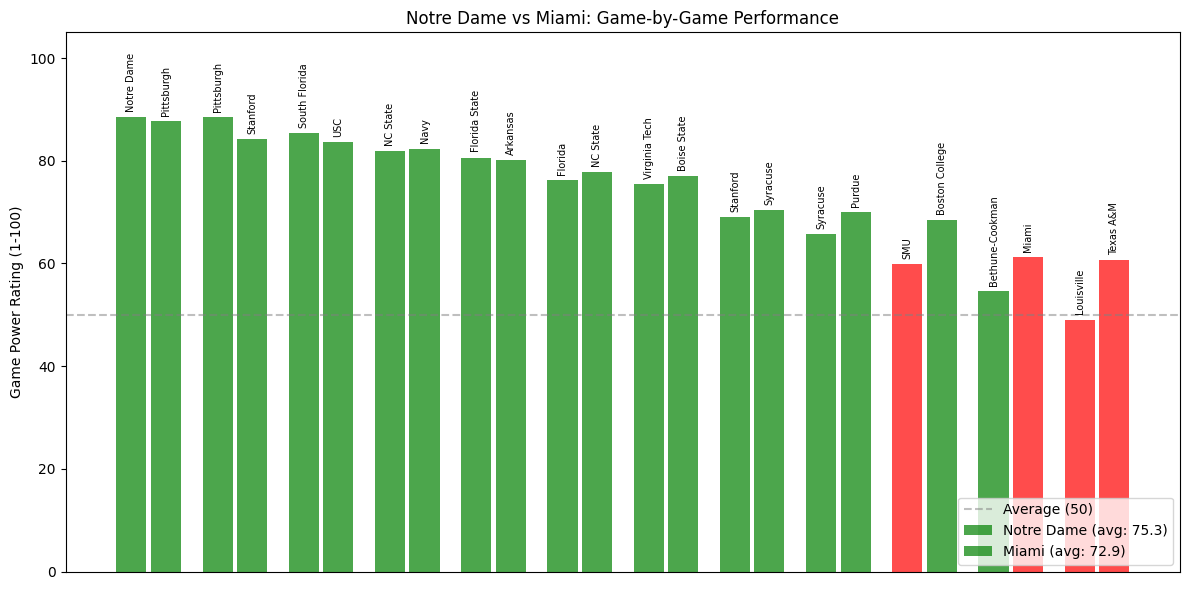


Visualization saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\notre_dame_miami_comparison.png


In [62]:
# =============================================================================
# DIAGNOSTIC
# =============================================================================
print("\n" + "="*90)
print("DIAGNOSTIC: Notre Dame vs Miami")
print("="*90)

for team_to_check in ['Notre Dame', 'Miami']:
    print(f"\n{team_to_check}:")
    print(f"  Avg Performance: {avg_perf[team_to_check]:.4f}")
    print(f"  Power Logit: {power_logit[team_to_check]:.4f}")
    print(f"  Power Score: {power_scores[team_to_check]:.4f}")
    print(f"  SOS: {sos[team_to_check]:.4f}")
    
    print(f"\n  Game-by-game implied power:")
    implied_powers = []
    for g in team_games[team_to_check]:
        opp = g['opponent']
        perf = g['performance']
        perf_logit = prob_to_logit(perf)
        opp_logit = power_logit[opp]
        opp_prob = power_scores[opp]
        
        if g['neutral']:
            hfa_adj = 0
            venue = 'N'
        elif g['is_home']:
            hfa_adj = -HFA_LOGIT
            venue = 'H'
        else:
            hfa_adj = +HFA_LOGIT
            venue = 'A'
        
        implied = perf_logit + opp_logit + hfa_adj
        implied_powers.append(implied)
        game_rating = logit_to_100(implied)
        result = "W" if perf > 0.5 else "L"
        print(f"    {result} {venue} vs {opp:25} perf={perf:.3f} opp_pwr={opp_prob:.3f} implied_logit={implied:.3f} rating={game_rating:.1f}")
    
    print(f"\n  Mean implied logit: {np.mean(implied_powers):.4f}")

# =============================================================================
# VISUALIZATION: Game-by-game comparison
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

for idx, team_to_check in enumerate(['Notre Dame', 'Miami']):
    game_data = []
    for g in team_games[team_to_check]:
        opp = g['opponent']
        perf = g['performance']
        perf_logit = prob_to_logit(perf)
        opp_logit = power_logit[opp]
        
        if g['neutral']:
            hfa_adj = 0
        elif g['is_home']:
            hfa_adj = -HFA_LOGIT
        else:
            hfa_adj = +HFA_LOGIT
        
        implied = perf_logit + opp_logit + hfa_adj
        game_rating = logit_to_100(implied)
        game_data.append({
            'opponent': opp,
            'game_rating': game_rating,
            'win': perf > 0.5
        })
    
    # Sort by game rating
    game_data = sorted(game_data, key=lambda x: x['game_rating'], reverse=True)
    
    x_positions = np.arange(len(game_data))
    ratings = [g['game_rating'] for g in game_data]
    colors = ['green' if g['win'] else 'red' for g in game_data]
    
    offset = 0.2 if idx == 0 else -0.2
    bars = ax.bar(x_positions + offset, ratings, width=0.35, color=colors, alpha=0.7, 
                  label=f"{team_to_check} (avg: {np.mean(ratings):.1f})")
    
    # Add opponent labels
    for i, g in enumerate(game_data):
        ax.text(i + offset, ratings[i] + 1, g['opponent'], rotation=90, 
                ha='center', va='bottom', fontsize=7)

ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Average (50)')
ax.set_ylabel('Game Power Rating (1-100)')
ax.set_title('Notre Dame vs Miami: Game-by-Game Performance')
ax.set_xticks([])
ax.set_ylim(0, 105)
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f'{data_path}\\notre_dame_miami_comparison.png', dpi=150)
plt.show()

print(f"\nVisualization saved to {data_path}\\notre_dame_miami_comparison.png")

In [60]:
# =============================================================================
# COMPARABLE GAMES FINDER
# =============================================================================

# ENTER GAME TO ANALYZE
team_of_interest = 'Miami'
opponent_of_interest = 'Louisville'

# Find the game and its rating from team_of_interest's perspective
target_game = None
target_rating = None

for g in team_games[team_of_interest]:
    if g['opponent'] == opponent_of_interest:
        perf_logit = prob_to_logit(g['performance'])
        opp_logit = power_logit[g['opponent']]
        
        if g['neutral']:
            hfa_adj = 0
        elif g['is_home']:
            hfa_adj = -HFA_LOGIT
        else:
            hfa_adj = +HFA_LOGIT
        
        implied = perf_logit + opp_logit + hfa_adj
        target_rating = logit_to_100(implied)
        target_game = g
        target_was_win = g['performance'] > 0.5
        break

if target_rating is None:
    print(f"Game not found: {team_of_interest} vs {opponent_of_interest}")
else:
    result = "W" if target_was_win else "L"
    print(f"Target Game: {team_of_interest} {result} vs {opponent_of_interest}")
    print(f"Game Power Rating: {target_rating:.1f}")
    print("\n" + "="*100)
    
    # Build list of all game performances (each game creates 2 entries - one per team)
    all_performances = []
    
    for _, game in df.iterrows():
        home = game['homeTeam']
        away = game['awayTeam']
        home_pts = int(game['homePoints'])
        away_pts = int(game['awayPoints'])
        excitement = game['excitementIndex']
        neutral = game['neutralSite']
        dominance = excitement_to_dominance(excitement)
        
        home_win = home_pts > away_pts
        
        # Home team's perspective
        if home_win:
            home_perf = 0.5 + 0.5 * dominance
        else:
            home_perf = 0.5 - 0.5 * dominance
        
        home_perf_logit = prob_to_logit(home_perf)
        home_opp_logit = power_logit.get(away, 0)
        home_hfa_adj = 0 if neutral else -HFA_LOGIT
        home_implied = home_perf_logit + home_opp_logit + home_hfa_adj
        home_rating = logit_to_100(home_implied)
        
        all_performances.append({
            'team': home,
            'team_pts': home_pts,
            'opponent': away,
            'opp_pts': away_pts,
            'result': 'W' if home_win else 'L',
            'excitement': excitement,
            'venue': 'N' if neutral else 'H',
            'game_rating': home_rating
        })
        
        # Away team's perspective
        if home_win:
            away_perf = 0.5 - 0.5 * dominance
        else:
            away_perf = 0.5 + 0.5 * dominance
        
        away_perf_logit = prob_to_logit(away_perf)
        away_opp_logit = power_logit.get(home, 0)
        away_hfa_adj = 0 if neutral else +HFA_LOGIT
        away_implied = away_perf_logit + away_opp_logit + away_hfa_adj
        away_rating = logit_to_100(away_implied)
        
        all_performances.append({
            'team': away,
            'team_pts': away_pts,
            'opponent': home,
            'opp_pts': home_pts,
            'result': 'L' if home_win else 'W',
            'excitement': excitement,
            'venue': 'N' if neutral else 'A',
            'game_rating': away_rating
        })
    
    # Sort by distance from target rating
    all_performances = sorted(all_performances, key=lambda x: abs(x['game_rating'] - target_rating))
    
    # Get 10 above and 10 below
    above = sorted([g for g in all_performances if g['game_rating'] >= target_rating], 
                   key=lambda x: x['game_rating'])[:11]
    below = sorted([g for g in all_performances if g['game_rating'] < target_rating], 
                   key=lambda x: x['game_rating'], reverse=True)[:10]
    
    comparable = sorted(above + below, key=lambda x: x['game_rating'], reverse=True)
    
    print(f"\n{'Team':<25} {'W/L':<5} {'H/A':<5} {'Score':<10} {'Opponent':<25} {'Excite':>7} {'Rating':>7}")
    print("-"*100)
    
    for g in comparable:
        score = f"{g['team_pts']}-{g['opp_pts']}"
        is_target = g['team'] == team_of_interest and g['opponent'] == opponent_of_interest
        marker = " <--" if is_target else ""
        print(f"{g['team']:<25} {g['result']:<5} {g['venue']:<5} {score:<10} {g['opponent']:<25} {g['excitement']:>7.2f} {g['game_rating']:>7.1f}{marker}")

Target Game: Miami L vs Louisville
Game Power Rating: 49.1


Team                      W/L   H/A   Score      Opponent                   Excite  Rating
----------------------------------------------------------------------------------------------------
Virginia Tech             L     H     16-28      Louisville                   6.18    49.2
South Dakota              W     H     24-17      Northern Colorado            5.59    49.2
Louisiana                 W     H     34-10      McNeese                      4.59    49.2
Missouri                  W     H     42-6       Massachusetts                3.11    49.2
Duke                      L     H     19-45      Illinois                     5.06    49.2
Southern Utah             W     A     36-34      North Alabama                6.62    49.2
Cal Poly                  L     A     9-28       Montana                      6.19    49.2
Georgia State             W     H     37-21      Murray State                 3.75    49.1
Northwestern       

In [61]:
# =============================================================================
# GAME RATING DIAGNOSTIC
# =============================================================================

games_to_compare = [
    ('Abilene Christian', 'Eastern Kentucky'),
    ('Miami', 'Louisville')
]

print("="*100)
print("GAME RATING BREAKDOWN")
print("="*100)

for team, opponent in games_to_compare:
    print(f"\n{team} vs {opponent}:")
    print("-"*80)
    
    # Find the game in original dataframe for full details
    game_row = df[((df['homeTeam'] == team) & (df['awayTeam'] == opponent)) | 
                  ((df['homeTeam'] == opponent) & (df['awayTeam'] == team))].iloc[0]
    
    home_team = game_row['homeTeam']
    away_team = game_row['awayTeam']
    home_pts = int(game_row['homePoints'])
    away_pts = int(game_row['awayPoints'])
    excitement = game_row['excitementIndex']
    neutral = game_row['neutralSite']
    
    print(f"  Venue: {home_team} (home) vs {away_team} (away) {'[NEUTRAL]' if neutral else ''}")
    print(f"  Score: {home_team} {home_pts} - {away_team} {away_pts}")
    print(f"  Excitement Index: {excitement:.2f}")
    
    dominance = excitement_to_dominance(excitement)
    print(f"  Dominance: {dominance:.3f}")
    
    # Find from team's perspective
    for g in team_games[team]:
        if g['opponent'] == opponent:
            perf = g['performance']
            perf_logit = prob_to_logit(perf)
            opp_pwr = power_scores[opponent]
            opp_logit = power_logit[opponent]
            
            # HFA adjustment
            if g['neutral']:
                hfa_adj = 0
                venue_desc = "NEUTRAL"
            elif g['is_home']:
                hfa_adj = -HFA_LOGIT
                venue_desc = "HOME (penalty)"
            else:
                hfa_adj = +HFA_LOGIT
                venue_desc = "AWAY (bonus)"
            
            implied = perf_logit + opp_logit + hfa_adj
            rating = logit_to_100(implied)
            
            result = "WIN" if perf > 0.5 else "LOSS"
            
            print(f"\n  {team}'s perspective ({result}, {venue_desc}):")
            print(f"    Performance: {perf:.3f}")
            print(f"    Performance Logit: {perf_logit:.3f}")
            print(f"    Opponent Power Score: {opp_pwr:.3f}")
            print(f"    Opponent Power Logit: {opp_logit:.3f}")
            print(f"    HFA Adjustment: {hfa_adj:+.3f}")
            print(f"    Implied Logit (perf + opp + hfa): {implied:.3f}")
            print(f"    Game Rating (1-100): {rating:.1f}")
            break

GAME RATING BREAKDOWN

Abilene Christian vs Eastern Kentucky:
--------------------------------------------------------------------------------
  Venue: Eastern Kentucky (home) vs Abilene Christian (away) 
  Score: Eastern Kentucky 10 - Abilene Christian 17
  Excitement Index: 6.34
  Dominance: 0.706

  Abilene Christian's perspective (WIN, AWAY (bonus)):
    Performance: 0.853
    Performance Logit: 1.758
    Opponent Power Score: 0.223
    Opponent Power Logit: -1.250
    HFA Adjustment: +0.393
    Implied Logit (perf + opp + hfa): 0.900
    Game Rating (1-100): 55.2

Miami vs Louisville:
--------------------------------------------------------------------------------
  Venue: Miami (home) vs Louisville (away) 
  Score: Miami 21 - Louisville 24
  Excitement Index: 6.08
  Dominance: 0.721

  Miami's perspective (LOSS, HOME (penalty)):
    Performance: 0.139
    Performance Logit: -1.821
    Opponent Power Score: 0.910
    Opponent Power Logit: 2.317
    HFA Adjustment: -0.393
    Impli

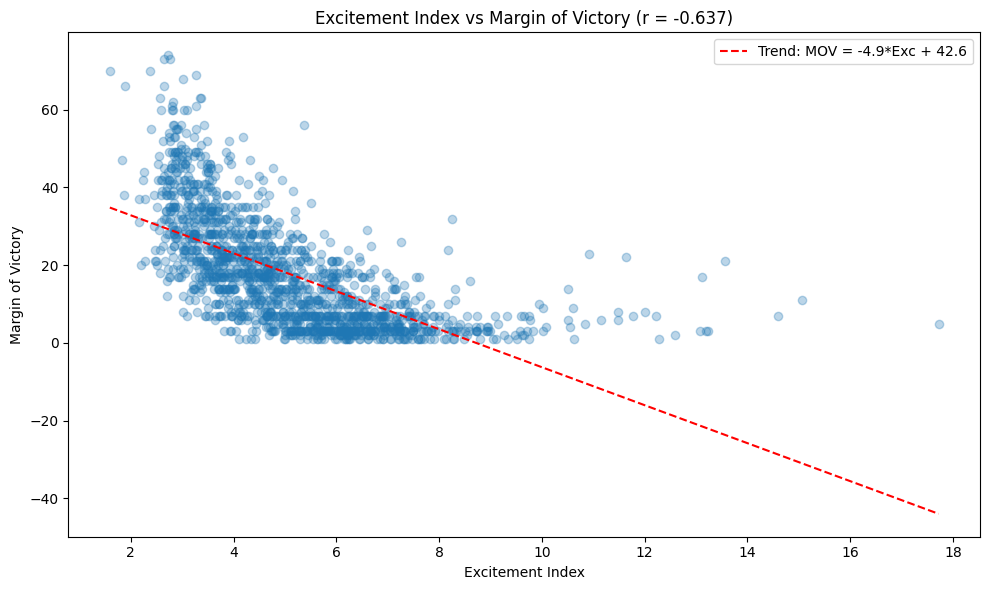


Correlation: -0.637
Saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\excitement_vs_mov.png


In [65]:
# =============================================================================
# EXCITEMENT INDEX vs MARGIN OF VICTORY
# =============================================================================

import matplotlib.pyplot as plt

# Calculate margin of victory for each game
mov_data = []

for _, game in df.iterrows():
    home_pts = game['homePoints']
    away_pts = game['awayPoints']
    excitement = game['excitementIndex']
    
    mov = abs(home_pts - away_pts)
    mov_data.append({
        'mov': mov,
        'excitement': excitement
    })

movs = [g['mov'] for g in mov_data]
excitements = [g['excitement'] for g in mov_data]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(excitements, movs, alpha=0.3)

# Add trend line
z = np.polyfit(excitements, movs, 1)
p = np.poly1d(z)
x_line = np.linspace(min(excitements), max(excitements), 100)
ax.plot(x_line, p(x_line), "r--", label=f'Trend: MOV = {z[0]:.1f}*Exc + {z[1]:.1f}')

# Correlation
corr = np.corrcoef(excitements, movs)[0, 1]

ax.set_xlabel('Excitement Index')
ax.set_ylabel('Margin of Victory')
ax.set_title(f'Excitement Index vs Margin of Victory (r = {corr:.3f})')
ax.legend()

plt.tight_layout()
plt.savefig(f'{data_path}\\excitement_vs_mov.png', dpi=150)
plt.show()

print(f"\nCorrelation: {corr:.3f}")
print(f"Saved to {data_path}\\excitement_vs_mov.png")

In [69]:
# =============================================================================
# CLEANER MODEL: Learn how much dominance matters
# =============================================================================

# We'll use logistic regression to predict game outcomes based on:
# 1. Team power difference
# 2. Home field advantage
# 
# Then we'll test: does adding dominance from PREVIOUS games improve prediction?

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# First, build basic Bradley-Terry (wins/losses only)
# Initialize all teams at 0
power_logit = {team: 0.0 for team in teams}

# =============================================================================
# Step 1 FIXED: Proper Bradley-Terry (wins/losses only)
# =============================================================================

print("Step 1 FIXED: Proper Bradley-Terry (wins/losses only)")
print("="*60)

power_logit = {team: 0.0 for team in teams}

for iteration in range(100):
    new_power = {}
    
    for team in teams:
        implied_powers = []
        
        for g in team_games[team]:
            opp = g['opponent']
            opp_power = power_logit[opp]
            
            # HFA adjustment
            if g['neutral']:
                hfa = 0
            elif g['is_home']:
                hfa = -HFA_LOGIT  # Home team had advantage, adjust down
            else:
                hfa = HFA_LOGIT   # Road team overcame disadvantage, adjust up
            
            # Win = you showed you're better than opponent
            # Loss = you showed you're worse than opponent
            if g['performance'] > 0.5:  # Win
                # A win implies: team_power > opp_power (adjusted for HFA)
                # Use a moderate bonus for winning
                implied = opp_power + 1.0 + hfa
            else:  # Loss
                # A loss implies: team_power < opp_power
                implied = opp_power - 1.0 + hfa
            
            implied_powers.append(implied)
        
        new_power[team] = np.mean(implied_powers) if implied_powers else 0
    
    # Center
    mean_p = np.mean(list(new_power.values()))
    new_power = {t: p - mean_p for t, p in new_power.items()}
    
    max_change = max(abs(new_power[t] - power_logit[t]) for t in teams)
    power_logit = new_power
    
    if max_change < 0.001:
        print(f"Converged at iteration {iteration}")
        break

power_prob = {t: 1 / (1 + np.exp(-p)) for t, p in power_logit.items()}

print("\nTop 25 (wins/losses only):")
for i, (team, prob) in enumerate(sorted(power_prob.items(), key=lambda x: -x[1])[:25], 1):
    logit = power_logit[team]
    print(f"  {i:2}. {team:20} {prob:.3f} (logit: {logit:+.2f})")

# =============================================================================
# Step 2: Now test if dominance adds predictive value
# =============================================================================

print("\n" + "="*60)
print("Step 2: Testing if dominance adds predictive value")
print("="*60)

# Build dataset for prediction
# For each game, we want to predict: did home team win?
# Features: power_diff, is_neutral, and optionally: avg_dominance_diff

game_features = []

for _, game in df.iterrows():
    home = game['homeTeam']
    away = game['awayTeam']
    home_win = 1 if game['homePoints'] > game['awayPoints'] else 0
    neutral = 1 if game['neutralSite'] else 0
    
    # Power difference (home - away)
    power_diff = power_logit.get(home, 0) - power_logit.get(away, 0)
    
    # Average dominance in previous games for each team
    home_dom = np.mean([g['performance'] for g in team_games[home]]) if team_games[home] else 0.5
    away_dom = np.mean([g['performance'] for g in team_games[away]]) if team_games[away] else 0.5
    dom_diff = home_dom - away_dom
    
    game_features.append({
        'home_win': home_win,
        'power_diff': power_diff,
        'neutral': neutral,
        'dom_diff': dom_diff
    })

feat_df = pd.DataFrame(game_features)

# Model 1: Power + HFA only
X1 = feat_df[['power_diff', 'neutral']]
y = feat_df['home_win']

model1 = LogisticRegression()
scores1 = cross_val_score(model1, X1, y, cv=5, scoring='accuracy')
print(f"\nModel 1 (Power + HFA only):")
print(f"  CV Accuracy: {scores1.mean():.3f} (+/- {scores1.std()*2:.3f})")

# Model 2: Power + HFA + Dominance
X2 = feat_df[['power_diff', 'neutral', 'dom_diff']]

model2 = LogisticRegression()
scores2 = cross_val_score(model2, X2, y, cv=5, scoring='accuracy')
print(f"\nModel 2 (Power + HFA + Dominance):")
print(f"  CV Accuracy: {scores2.mean():.3f} (+/- {scores2.std()*2:.3f})")

# Fit full model to see coefficients
model2.fit(X2, y)
print(f"\nModel 2 Coefficients:")
print(f"  Power Diff: {model2.coef_[0][0]:.3f}")
print(f"  Neutral: {model2.coef_[0][1]:.3f}")
print(f"  Dominance Diff: {model2.coef_[0][2]:.3f}")

# =============================================================================
# Step 3 FIXED: Scale dominance appropriately
# =============================================================================

print("\n" + "="*60)
print("Step 3 FIXED: Proper scaling of dominance")
print("="*60)

# The regression tells us:
# P(home_win) = logistic(0.689 * power_diff + 6.931 * dom_diff)
# 
# So for each 0.1 increase in dominance, it's worth 6.931 * 0.1 = 0.693 logit
# For each 1.0 increase in power_diff, it's worth 0.689 logit
#
# BUT our Bradley-Terry power_diff is on a different scale
# Let's instead directly use the regression as our model

# Rebuild: each team's "strength" is a combination of:
# - Who they beat/lost to (opponent quality)
# - How dominantly they won/lost (performance)

# Let's use the regression coefficients directly
POWER_COEF = model2.coef_[0][0]  # 0.689
DOM_COEF = model2.coef_[0][2]    # 6.931

print(f"Using coefficients: Power={POWER_COEF:.3f}, Dominance={DOM_COEF:.3f}")

# Initialize
power_logit_v3 = {team: 0.0 for team in teams}

for iteration in range(100):
    new_power = {}
    
    for team in teams:
        implied_powers = []
        
        for g in team_games[team]:
            opp = g['opponent']
            opp_power = power_logit_v3[opp]
            perf = g['performance']
            
            # HFA in logit terms (from our earlier estimate)
            if g['neutral']:
                hfa = 0
            elif g['is_home']:
                hfa = -HFA_LOGIT
            else:
                hfa = HFA_LOGIT
            
            # The key insight: 
            # If we won with performance P, what power would make that expected?
            # P(win) = logistic(POWER_COEF * (us - opp) + DOM_COEF * (our_dom - 0.5))
            # 
            # For a win, we observed P(win) ≈ perf (roughly)
            # logit(perf) = POWER_COEF * (us - opp) + DOM_COEF * (perf - 0.5)
            # us = opp + [logit(perf) - DOM_COEF * (perf - 0.5)] / POWER_COEF
            
            perf_clipped = np.clip(perf, 0.01, 0.99)
            perf_logit = np.log(perf_clipped / (1 - perf_clipped))
            
            # What we showed we're capable of
            dom_contribution = DOM_COEF * (perf - 0.5) / POWER_COEF
            
            implied = opp_power + perf_logit / POWER_COEF + hfa
            implied_powers.append(implied)
        
        new_power[team] = np.mean(implied_powers) if implied_powers else 0
    
    # Center
    mean_p = np.mean(list(new_power.values()))
    new_power = {t: p - mean_p for t, p in new_power.items()}
    
    max_change = max(abs(new_power[t] - power_logit_v3[t]) for t in teams)
    power_logit_v3 = new_power
    
    if max_change < 0.001:
        print(f"Converged at iteration {iteration}")
        break

# Scale to reasonable range (divide by POWER_COEF to normalize)
power_logit_scaled = {t: p * POWER_COEF for t, p in power_logit_v3.items()}
power_prob_v3 = {t: 1 / (1 + np.exp(-p)) for t, p in power_logit_scaled.items()}

print("\nTop 25 (properly scaled):")
for i, (team, prob) in enumerate(sorted(power_prob_v3.items(), key=lambda x: -x[1])[:25], 1):
    logit = power_logit_scaled[team]
    print(f"  {i:2}. {team:20} {prob:.3f} (logit: {logit:+.2f})")

Step 1 FIXED: Proper Bradley-Terry (wins/losses only)
Converged at iteration 34

Top 25 (wins/losses only):
   1. Indiana              0.787 (logit: +1.30)
   2. Ohio State           0.762 (logit: +1.16)
   3. Oregon               0.760 (logit: +1.15)
   4. BYU                  0.756 (logit: +1.13)
   5. Georgia              0.755 (logit: +1.13)
   6. Oklahoma             0.741 (logit: +1.05)
   7. Texas Tech           0.739 (logit: +1.04)
   8. Texas A&M            0.733 (logit: +1.01)
   9. Montana State        0.729 (logit: +0.99)
  10. Ole Miss             0.724 (logit: +0.96)
  11. Utah                 0.724 (logit: +0.96)
  12. Tulane               0.723 (logit: +0.96)
  13. North Texas          0.717 (logit: +0.93)
  14. Notre Dame           0.716 (logit: +0.93)
  15. James Madison        0.709 (logit: +0.89)
  16. Alabama              0.705 (logit: +0.87)
  17. Michigan             0.705 (logit: +0.87)
  18. USC                  0.702 (logit: +0.86)
  19. Vanderbilt           0